# Read in training data

In [4]:
import os
import glob

basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+"/*.png"))

print("Vehicle Images: ",len(cars))

with open('cars.txt','w') as f:
    for fn in cars:
        f.write(fn+"\n")

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+"/*.png"))

print("Non -Vehicle Images: ",len(not_cars))

with open('not_cars.txt','w') as f:
    for fn in not_cars:
        f.write(fn+"\n")

Vehicle Images:  8792
Non -Vehicle Images:  8968


# Define relevant functions

In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0],size).ravel()
    color2 = cv2.resize(img[:,:,1],size).ravel()
    color3 = cv2.resize(img[:,:,2],size).ravel()
    # Return the feature vector
    return np.hstack((color1,color2,color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis==True:
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features),hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Function for plotting multiple images
def visualize(fig,rows,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

# Plot Single Car/Not Car

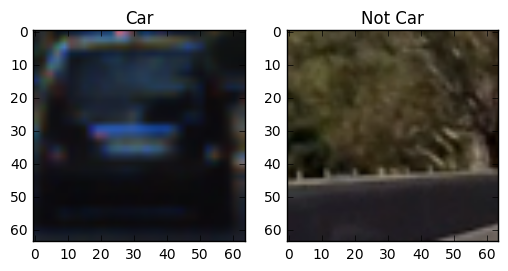

In [5]:
%matplotlib inline

#get random car/notcar indices
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

#get image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

visualize(None,1,2,[car_image,notcar_image],['Car','Not Car'])
#define features 


# Histogram of Oriented Gradients

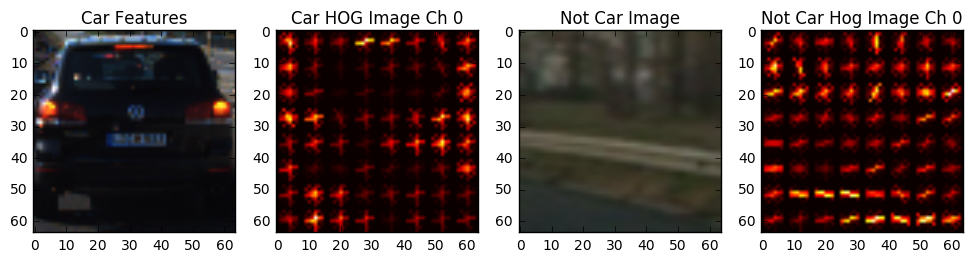

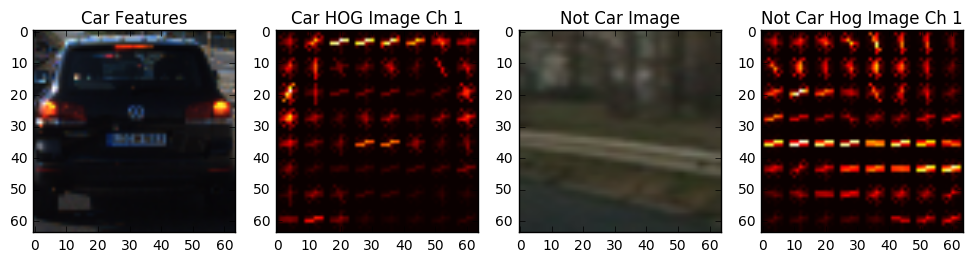

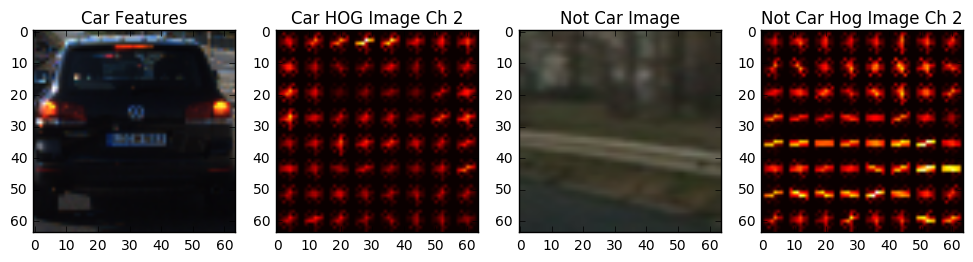

In [30]:
color_space = 'YUV' # Can be 
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
#hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

#Print each HOG channel 
for hog_channel in [0,1,2]:
    car_features,car_hog_image = single_img_features(car_image, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,vis=True)
    notcar_features,notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,vis=True)

    imgs= [car_image,car_hog_image,notcar_image,notcar_hog_image]
    titles = ['Car Features','Car HOG Image'+ ' Ch ' + str(i), "Not Car Image", "Not Car Hog Image"+ ' Ch ' + str(i)]
    fig = plt.figure(figsize=(12,3))
    visualize(fig,1,4,imgs,titles)

In [7]:
def train_test_model(train_cars,train_not_cars,
                     color_space,spatial_size,hist_bins,orient,
                     pix_per_cell,cell_per_block,hog_channel,
                     spatial_feat,hist_feat,hog_feat):
    
    t = time.time()
    car_features = extract_features(train_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(train_not_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    time_to_extract_features = round(time.time()-t,0)
    #print(time.time()-t," seconds to extract features")

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.1, random_state=rand_state)

    #print('Using:',color_space, 'color space', orient,'orientations',pix_per_cell,
    #    'pixels per cell and', cell_per_block,'cells per block',
    #     hist_bins,'histogram bins, and',spatial_size, ' spatial sampling')
    #print('Feature vector length:', len(X_train[0]))
    feature_length = len(X_train[0])
    
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    #print(round(t2-t, 2), 'Seconds to train SVC...')
    time_to_train = round(t2-t, 0)
    # Check the score of the SVC
    #print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    test_acc = round(svc.score(X_test, y_test), 4)
    # Check the prediction time for a single sample
    t=time.time()
    return svc,time_to_extract_features,time_to_train,feature_length,test_acc

# Picking parameters with a simple grid search

In [ ]:
# Simple grid search over different color spaces, and settings for various parameters.
n_samples = 1000
random_indxs = np.random.randint(0,len(cars), n_samples)
train_cars = np.array(cars)[random_indxs]
train_not_cars = np.array(not_cars)[random_indxs]
results = []
count = 0
for color_space in ['HSV','HLS', 'YCrCb']: #'RGB','LUV', 'YUV'
    for orient in [6,9]:
        for pix_per_cell in [8]:
            for hog_channel in ['ALL']:
                for spatial_size in [(16,16),(32,32)]:
                    for hist_bins in [16,32]:
                        for spatial_feat in [True]:
                            for hist_feat in [True]:
                                for hog_feat in [True]:
                                    if (spatial_feat or hist_feat or hog_feat):
                                        svc,time_to_extract_features,time_to_train,feature_length,test_acc = train_test_model(train_cars,train_not_cars,color_space,
                                                                                                                              spatial_size,hist_bins,orient,pix_per_cell,
                                                                                                                              cell_per_block,hog_channel,spatial_feat,
                                                                                                                              hist_feat,hog_feat)
                                        results.append([time_to_extract_features,time_to_train,color_space,orient,
                                                        spatial_size,hist_bins,test_acc])
                                        
                                        count += 1
                                        if count % 10 == 0:
                                            print(count)

In [55]:
import tabulate
header = ["Extract Time (s)","Train Time (S)","Color Space",'Orientation', "Spatial Size","Hist Bins", "Accuracy"]
print(tabulate.tabulate(results,header))


  Extract Time (s)    Train Time (S)  Color Space      Orientation  Spatial Size      Hist Bins    Accuracy
------------------  ----------------  -------------  -------------  --------------  -----------  ----------
                11                 6  HSV                        6  (16, 16)                 16       0.985
                10                 5  HSV                        6  (16, 16)                 32       0.99
                 9                 3  HSV                        6  (32, 32)                 16       0.98
                 9                 7  HSV                        6  (32, 32)                 32       0.99
                 9                 8  HSV                        9  (16, 16)                 16       0.985
                10                 8  HSV                        9  (16, 16)                 32       0.985
                 9                11  HSV                        9  (32, 32)                 16       0.995
                 9             

- YCrCB has the highest test accuracy above at 100% (trained on 900 images, and tested on 100).
- Select parameters are 6 orientations, (32,32) spatial size with 16 bins
- It's noted that the train/test size is quite small (this is mostly just a demonstration of how a grid search could be done to select parameters). So, i will use these results to select a color space, but other intuition to fill in paramter choices.
- Additionally, not all parameters were allowed to vary (e.g.: hog_channel is set to 'All'). This was to limit the time it took to return results. If project video performance is poor with these selected parameters, a more intensive search will be attempted later.
- For example, I will set the desired orientations to 9 based on the paper results, and increase the number of histogram bins to 32.


# Train SVC on all data given selected parameters

In [8]:
color_space = 'YCrCb' # Can be 
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
test_cars = cars 
test_not_cars = not_cars 

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t," seconds to extract features")

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',color_space, 'color space', orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block',
     hist_bins,'histogram bins, and',spatial_size, ' spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



113.55022501945496  seconds to extract features
Using: YCrCb color space 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32)  spatial sampling
Feature vector length: 8460
297.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


- Pretty good test accuracy from the SVC. We will still have many false positives since hundreds of windows need to be searched in each frame.
- So, some thresholding technique will need to be applied to the integral of the heatmap of detections to remove false positives.
- until then, let's quickly take a look at the bounding boxes drawn on some test images

# Sliding Window Search

## Approach 1

In [76]:
example_images = glob.glob('test_images/test1.jpg')
images = []
titles = []
y_start_stop = [400,656]
overlap = .5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img),np.max(img))
    
    windows = slide_window(img,x_start_stop=[None,None],y_start_stop=y_start_stop,
                          xy_window = (64,64),xy_overlap=(overlap,overlap))
    
    window_img = draw_boxes(draw_img,windows,color=(0,0,255),thick=6)
    
    images.append(window_img)
    titles.append('')
    print(round(time.time()-t1,4),'seconds needed to process 1 image', len(windows),'windows')

0.0 1.0
0.1159 seconds needed to process 1 image 273 windows


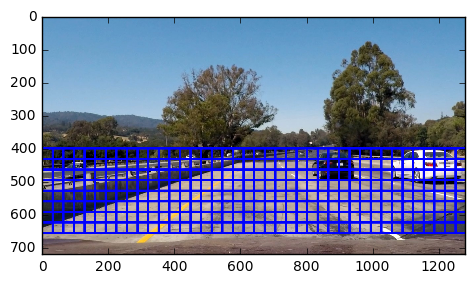

In [77]:
fig = plt.figure(figsize=(12,18),dpi=300)
visualize(fig,5,2,images,titles)

- Using y_start_stop allows us to restrict the space where we search for cars. Thats a performance gain and reduces likelihood of false positives in those areas.
- We want to use subsampling to speed up creation of hog features
- We may also want to try searching windows of different sizes too.

## Approach 2

In [9]:
def convert_color(img,conv='RGB2YCrCb'):
    if conv=='RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv=='BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv=='RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
    return draw_img
    


In [19]:
ystart = 400
ystop = 656
scale = 2
    
example_images = glob.glob('test_images/*.jpg')
images = []
titles = []
y_start_stop = [400,656]
overlap = .5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    print(round(time.time()-t1,4),'seconds needed to process 1 image')
    images.append(out_img)
    titles.append(img_src)


0.6506 seconds needed to process 1 image
0.2283 seconds needed to process 1 image
0.2965 seconds needed to process 1 image
0.2608 seconds needed to process 1 image
0.2344 seconds needed to process 1 image
0.2785 seconds needed to process 1 image


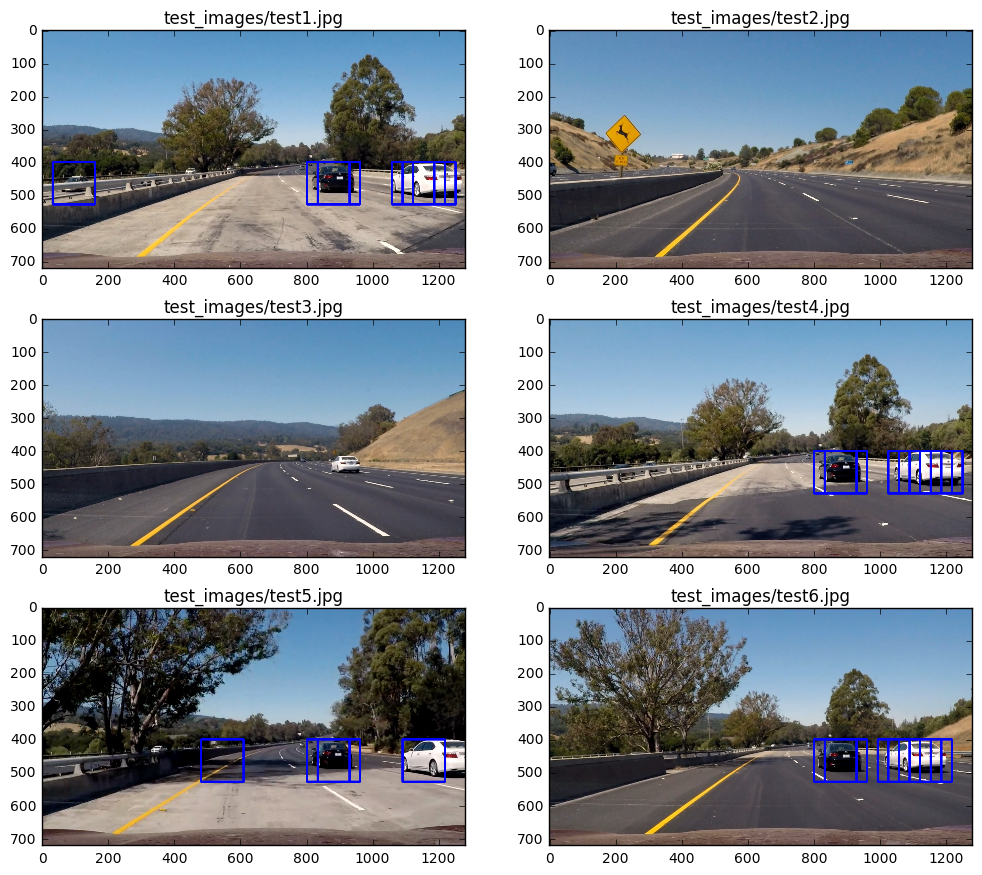

In [20]:
fig = plt.figure(figsize=(12,18),dpi=300)
visualize(fig,5,2,images,titles)

- Notice there is a false negative in image 3 and a false positives in images 1 and 5
- Will try to use heatmaps + threhsolding to remove the false positive.
- modifying the y_start does not seem to help identifying the car in image 3. will explore other methods later

# Incorporate Heatmaps into Find Cars Function

In [11]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [22]:
# Find Cars with heatmap code
def find_cars(img, scale):
    
    draw_img = np.copy(img)
    #heatmap
    heatmap = np.zeros_like(img[:,:,0])
    img_boxes = []
    
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img,heatmap
    


0.5207 seconds needed to process 1 image
0.471 seconds needed to process 1 image
0.4414 seconds needed to process 1 image
0.4459 seconds needed to process 1 image
0.4463 seconds needed to process 1 image
0.4374 seconds needed to process 1 image


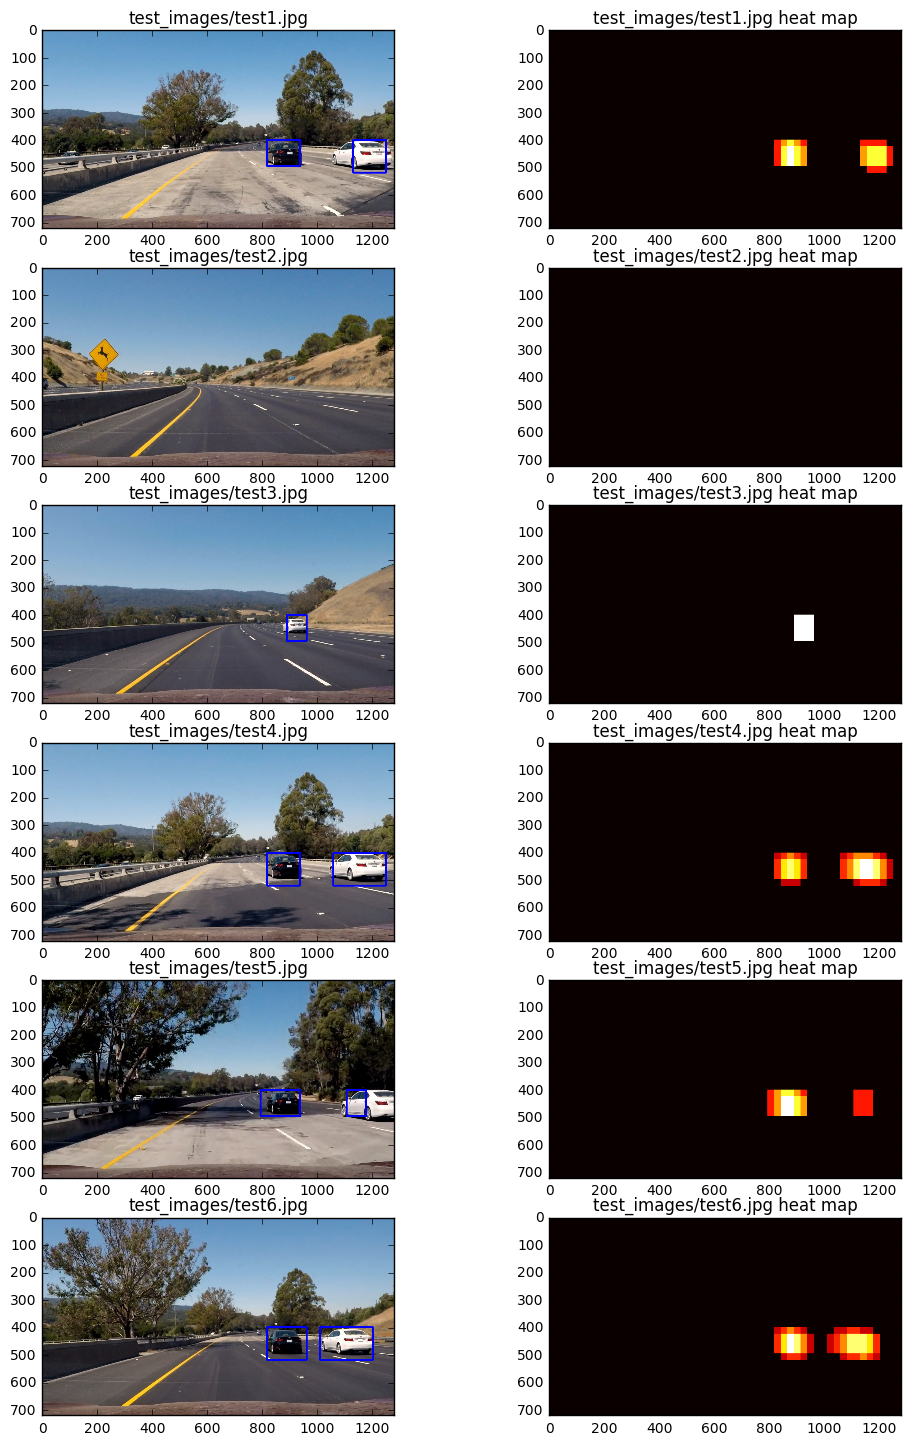

In [106]:
example_images = glob.glob('test_images/*.jpg')
images = []
titles = []
maps = []
y_start,y_stop = 400,656
scale = 1.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    out_img,heat_map = find_cars(img, scale)
    heat_map = apply_threshold(heat_map,threshold=1)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    print(round(time.time()-t1,4),'seconds needed to process 1 image')
    images.append(draw_img)
    images.append(heat_map)
    titles.append(img_src)
    titles.append(img_src + " heat map")
    
fig = plt.figure(figsize=(12,24))
visualize(fig,8,2,images,titles)

- Pretty good results. 
- All cars were detected, no false positves!
- By using apply_threshold with a threshold of 1, false positives were removed (without losing any true positives).

# Project Video

In [13]:
class HeatMaps ():
    """Class to store heat maps from last 10 frames
    """
    def __init__ (self):
        self.max_maps = 10 # number items to store
        self.maps = []

    def put_map (self, heat_map):
        """Put heat map
        """
        if len(self.maps) > self.max_maps:
            self.maps.pop(0)
        
        self.maps.append(heat_map)
        
    def get_map (self):
        """Get last max_map heat maps
        """
        return self.maps
    
    def get_summed_map(self):
        return sum(self.maps)
    
    def get_max_maps(self):
        return self.max_maps


In [14]:
heatmaps = HeatMaps()
scales = [1,1.5,2]
def process_image(img):
    out_img,heat_map = find_cars(img,scales[1])
    heatmaps.put_map(heat_map)
    heat_map = heatmaps.get_summed_map()
    heat_map = apply_threshold(heat_map,len(heatmaps.get_map()))
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    return draw_img

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#test_output = 'test.mp4'
full_output = 'project.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(full_output,audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [09:38<00:00,  1.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

